# Assignment 2
## Airbnb prediction models
Business: Your task will be to help a company operating small and mid-size apartments hosting 2-6 guests. The company is set to price their new apartments not on the market.

Build a price prediction model similarly to how we did in our case study for London.

Discuss your modeling decisions and compare your results to those of the case study. 

### Scoring
Data prep, label and feature engineering (30%)

Model building, prediction and model selection (40%)

Discussion of steps, decisions and results (15%)

Quality of the write-up (15%)

## Data
I have a data from AirBNB for **Vienna** city


In [1]:
### SETTING UP DIRECTORIES

# import packages
import pandas as pd
import os
import numpy as np
import sys
import warnings
from pathlib import Path

from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import seaborn as sns
from mizani.formatters import percent_format
import regex as re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# set working directory for da_data_repo -- replace the
os.chdir('C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_2_AirBNB_data')

# location folders
data_in = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_2_AirBNB_data\\raw\\"
data_out = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_2_AirBNB_data\\clean\\"
results = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_2_AirBNB_data\\results\\"
func = 'C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_2_AirBNB_data\\'

sys.path.append(func)
from py_helper_functions import *

## Importing data
The first thing to be done is to get data, import it, and keep only the variables and observations I need for models

In [2]:
data = pd.read_csv(data_in + "listings.csv", index_col=0)

Change pandas options, so that we could see all the columns and their values. Double check whether all values imported correctly

In [3]:
pd.set_option('display.max_columns', None)
data.head()

,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15883,https://www.airbnb.com/rooms/15883,20210912145155,2021-09-13,b&b near Old Danube river,"Four rooms, each one differently and individua...",small and personal<br /><br />Four rooms at th...,https://a0.muscache.com/pictures/18eff738-a737...,62142,https://www.airbnb.com/users/show/62142,Eva,2009-12-11,"Vienna, Wien, Austria",Mein größtes Hobby: Reisen! Am liebsten mit me...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/24166...,https://a0.muscache.com/im/pictures/user/24166...,Donaustadt,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Vienna, Austria",Donaustadt,NaN,48.24262,16.42767,Room in bed and breakfast,Hotel room,3,NaN,1 bath,1.0,2.0,"[""Hair dryer"", ""Wifi"", ""Heating"", ""Essentials""...",$120.00,1,365,1,1,365,365,1.0,365.0,NaN,t,24,54,84,359,2021-09-13,13,2,1,2017-11-19,2019-07-17,4.69,4.85,5.00,4.92,4.85,4.69,4.46,NaN,f,3,1,0,0,0.28
38768,https://www.airbnb.com/rooms/38768,20210912145155,2021-09-12,central cityapartement- wifi- nice neighbourhood,39m² apartment with beautiful courtyard of the...,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,https://www.airbnb.com/users/show/166283,Hannes,2010-07-14,"Wien, Wien, Austria",I am open minded and like travelling myself. I...,NaN,NaN,NaN,t,https://a0.muscache.com/im/users/166283/profil...,https://a0.muscache.com/im/users/166283/profil...,Leopoldstadt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Vienna, Austria",Leopoldstadt,NaN,48.21924,16.37831,Entire rental unit,Entire home/apt,5,NaN,1 bath,1.0,3.0,"[""Cooking basics"", ""Stove"", ""Shampoo"", ""Host g...",$65.00,3,100,3,3,1125,1125,3.0,1125.0,NaN,t,0,30,60,147,2021-09-12,332,11,4,2012-06-16,2021-09-05,4.75,4.80,4.65,4.91,4.93,4.74,4.70,NaN,t,3,3,0,0,2.95
40625,https://www.airbnb.com/rooms/40625,20210912145155,2021-09-13,"Near Palace Schönbrunn, Apt. 1",Welcome to my Apt. 1!<br /><br />This is a 2be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,https://www.airbnb.com/users/show/175131,Ingela,2010-07-20,"Vienna, Wien, Austria",I´m originally from Sweden but have been livin...,within a few hours,95%,86%,t,https://a0.muscache.com/im/users/175131/profil...,https://a0.muscache.com/im/users/175131/profil...,Rudolfsheim-Fünfhaus,16.0,16.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Vienna, Austria",Rudolfsheim-Fnfhaus,NaN,48.18434,16.32701,Entire rental unit,Entire home/apt,6,NaN,1 bath,2.0,4.0,"[""Cooking basics"", ""Children\u2019s books and ...",$88.00,1,180,1,1

Original data has 11,583 observations and 74 columns

### Removing unnecessary columns
Get rid of columns we surely don't need.
Those include:
1. Name and description of a property: *'listing_url', 'scrape_id', 'last_scraped', 'name', 'neighborhood_overview', 'picture_url', 'license', 'room_type'*
2. Host information that we cannot change: *'host_id', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_since', 'host_location', 'host_acceptance_rate', 'host_is_superhost', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month'*
3. Variables that will not be available for a new apartment: *'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'*
4. Other variables: *'neighbourhood', 'neighbourhood_group_cleansed', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated'*

In [4]:
list(data.columns)

['listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_

In [5]:
# select a subset of columns
data= data[
        [
         'description',
         'host_response_time', 
         'host_response_rate', 
         'host_has_profile_pic',
         'host_identity_verified',
         'neighbourhood_cleansed',
         'latitude',
         'longitude',
         'property_type',
         'accommodates',
         'bathrooms_text',
         'bedrooms',
         'beds',
         'amenities',
         'price',
         'minimum_nights',
         'maximum_nights',         
         'instant_bookable',
        ]
]

### Cleaning data and transforming variables
Now, we need to look at each column in the data and make sure that:
1. there are no missing variables
2. all variables are in the required format
3. the observations are comparable to our targets (e.g. we want to set price for apartments only)

#### Property type
First, I will look at *property_type*. As we need only apartments for our analysis, we need to get rid of other types

In [6]:
# count the number of missing values in the column
data["property_type"].isnull().sum().sum()

0

In [7]:
data["property_type"].value_counts()

Entire rental unit                     7410
Private room in rental unit            2242
Entire condominium (condo)              508
Entire serviced apartment               349
Entire loft                             167
Private room in condominium (condo)     111
Private room in residential home        108
Entire residential home                 104
Room in boutique hotel                   75
Room in hotel                            67
Shared room in rental unit               58
Private room in bed and breakfast        53
Private room in hostel                   53
Room in serviced apartment               36
Room in aparthotel                       25
Private room in loft                     24
Entire guest suite                       21
Private room in guesthouse               15
Private room in townhouse                15
Entire townhouse                         13
Shared room in hostel                    13
Entire villa                             11
Private room in serviced apartme

Let us look at properties, where hosts included word "apartment" in the description 

Some hosts include this word to describe their company name or surroundings

In [8]:
# show value counts among properties where the word "apartment" was mentioned
data['description'] = data['description'].fillna("0")
data[data['description'].str.contains("apartment")]["property_type"].value_counts()

# drop description as I won't need it anymore
data = data.drop(['description'], axis=1)

In [9]:
# keep if property type is Entire rental unit, Entire condominium (condo), Entire serviced apartment, Entire loft
data = data.loc[lambda x: x["property_type"].isin(["Entire rental unit", "Entire condominium (condo)", "Entire serviced apartment", 'Entire loft'])]

I looked at several properties from each of the type and saw that those are apartments. I assume that Entire rental unit, Entire condominium (condo), Entire serviced apartment, Entire loft are in fact apartments. In fact, most of the descriptions of these categories included word "apartment".

Now I will rename each property type and convert the column to type "category"

In [10]:
# rename categories to shorter names

data["property_type"] = np.where(
    data["property_type"] == "Entire rental unit", "Apartment", data["property_type"]
)
data["property_type"] = np.where(
    data["property_type"] == "Entire condominium (condo)", "Condo", data["property_type"]
)
data["property_type"] = np.where(
    data["property_type"] == "Entire serviced apartment", "Serviced Apartment", data["property_type"]
)
data["property_type"] = np.where(
    data["property_type"] == "Entire loft", "Loft", data["property_type"]
)
# convert to type
data["property_type"] = data["property_type"].astype("category")

#### Accommodates
Now, switch to *accommodates* variable

As the business is interested only in hosting 2-6 guests, we should limit the data to those values

In [11]:
# count the number of missing values in the column
data["accommodates"].isnull().sum().sum()

0

In [12]:
# look at the possible values
data["accommodates"].value_counts()

2     2870
4     2662
3     1090
6      767
5      472
1      167
8      151
7      101
10      67
9       26
16      23
12      18
14      10
11       8
15       1
13       1
Name: accommodates, dtype: int64

In [13]:
# remove all values except 2 to 6
data = data[data['accommodates'] > 1]
data = data[data['accommodates'] < 7]

In [14]:
data["accommodates"].value_counts()

2    2870
4    2662
3    1090
6     767
5     472
Name: accommodates, dtype: int64

#### Bathrooms

In [15]:
# count the number of missing values in the column
data["bathrooms_text"].isnull().sum().sum()

3

In [16]:
# look on the three rows witg missing bathroom values
data[data['bathrooms_text'].isnull()]

,host_response_time,host_response_rate,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,instant_bookable
id,,,,,,,,,,,,,,,,,
900543,within an hour,60%,t,t,Leopoldstadt,48.22008,16.39704,Apartment,4,NaN,1.0,1.0,"[""Outlet covers"", ""Children\u2019s books and t...",$89.00,1,1125,t
40722519,a few days or more,0%,t,t,Rudolfsheim-Fnfhaus,48.18692,16.32225,Apartment,2,NaN,NaN,NaN,"[""Hair dryer"", ""Kitchen"", ""Washer"", ""Wifi"", ""H...",$40.00,1,365,f
50236890,within an hour,100%,t,t,Neubau,48.20347,16.35318,Apartment,2,NaN,1.0,NaN,"[""Hair dryer"", ""Kitchen"", ""Cooking basics"", ""W...",$51.00,7,10,t


In [17]:
# replace NA values with 1, as the apartments accommodate less than 4 person and have 1 bedroom
data['bathrooms_text'] = data['bathrooms_text'].fillna(1)

In [18]:
data["bathrooms_text"].value_counts()

1 bath       6056
1.5 baths    1547
2 baths       153
2.5 baths      55
Half-bath      28
0 baths         9
3 baths         6
3.5 baths       3
1               3
4.5 baths       1
Name: bathrooms_text, dtype: int64

In [19]:
# Replace values with numbers

data["bathrooms_text"] = np.where(
    data["bathrooms_text"] == "1 bath", "1", data["bathrooms_text"]
)
data["bathrooms_text"] = np.where(
    data["bathrooms_text"] == "1.5 baths", "1.5", data["bathrooms_text"]
)
data["bathrooms_text"] = np.where(
    data["bathrooms_text"] == "2 baths", "2", data["bathrooms_text"]
)
data["bathrooms_text"] = np.where(
    data["bathrooms_text"] == "2.5 baths", "2.5", data["bathrooms_text"]
)
data["bathrooms_text"] = np.where(
    data["bathrooms_text"] == "Half-bath", "0.5", data["bathrooms_text"]
)
data["bathrooms_text"] = np.where(
    data["bathrooms_text"] == "0 baths", "0", data["bathrooms_text"]
)
data["bathrooms_text"] = np.where(
    data["bathrooms_text"] == "3 baths", "3", data["bathrooms_text"]
)
data["bathrooms_text"] = np.where(
    data["bathrooms_text"] == "3.5 baths", "3.5", data["bathrooms_text"]
)
data["bathrooms_text"] = np.where(
    data["bathrooms_text"] == "4.5 baths", "4.5", data["bathrooms_text"]
)

# convert to type
data["bathrooms_text"] = data["bathrooms_text"].astype(float)

In [20]:
data["bathrooms_text"].value_counts()

1.0    6059
1.5    1547
2.0     153
2.5      55
0.5      28
0.0       9
3.0       6
3.5       3
4.5       1
Name: bathrooms_text, dtype: int64

In [21]:
# create a category variable out of number of bathroom variable
bins = pd.IntervalIndex.from_tuples([(0, 0.6), (0.9, 1.1), (1.4, 1.6), (1.9, 2.1), (2.1, 5)], closed="left")
f_bath = pd.cut(data["bathrooms_text"].to_list(), bins, labels=["0", "1", "1.5", "2", "3" ])
f_bath.categories = [0, 1, 2, 3, 4]
data["f_bathroom"] = f_bath

In [22]:
# rename a column
data = data.rename(columns={'bathrooms_text': 'n_bathroom'})

#### Host information
Work on variables that include *'host_response_time', 'host_response_rate', 'host_has_profile_pic', 'host_identity_verified'*

I pick those because host can control and change the values of those variables

In [23]:
# count the number of missing values in the column
print("Missing values")
print("For host_response_time:", data.host_response_time.isnull().sum(), "or", "{:.2f}".format(data.host_response_time.isnull().sum()/len(data.index)), "% of all dataset")
print("For host_response_rate:", data.host_response_rate.isnull().sum(), "or", "{:.2f}".format(data.host_response_rate.isnull().sum()/len(data.index)), "% of all dataset")
print("For host_has_profile_pic:", data.host_has_profile_pic.isnull().sum(), "or", "{:.2f}".format(data.host_has_profile_pic.isnull().sum()/len(data.index)), "% of all dataset")
print("For host_identity_verified:", data.host_identity_verified.isnull().sum(), "or", "{:.2f}".format(data.host_identity_verified.isnull().sum()/len(data.index)), "% of all dataset")

Missing values
For host_response_time: 2685 or 0.34 % of all dataset
For host_response_rate: 2685 or 0.34 % of all dataset
For host_has_profile_pic: 72 or 0.01 % of all dataset
For host_identity_verified: 72 or 0.01 % of all dataset


There are many missing values in *host_response_time* and *host_response_rate* - 34%.
I will drop those variables.

Regarding *host_has_profile_pic* and *host_identity_verified*, I will replace missing values with true, because most of the hosts have those values.

In [24]:
data['host_has_profile_pic'] = data['host_has_profile_pic'].fillna("t")
data['host_identity_verified'] = data['host_identity_verified'].fillna("t")

In [25]:
# format binary variables
for binary in [
    "host_has_profile_pic",
    "host_identity_verified"]:
    data[binary] = data[binary].replace({"t": True, "f": False})

In [26]:
data = data.drop(['host_response_time', 'host_response_rate'], axis=1)

#### Amenities
This column contains text with the description of all amenities the property has. I want to create dummy variables for each amenity mentioned in this column.

First, I create a dataframe which has all the dummy variables (using MultiLabelBinarizer)

Second, I combine columns which have common properties (like "wifi" and "fast wifi" or "nivea shampoo" and "shampoo")

Third, I get rid of columns which has less than 300 in sum

Last, I add those columns to the data

In [27]:
# First step
def striplist(l):
    return([x.strip() for x in l])

In [28]:
data['amenities'] = data['amenities'].str.replace('[', '').str.replace(']', '').str.replace('"', '').str.lower().str.split(',').apply(striplist)

In [29]:
mlb = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb.fit_transform(data['amenities']), columns=mlb.classes_, index=data.index)

In [30]:
# add prefix to know that those columns are dummies of amenities
amenities_df=amenities_df.add_prefix('am_')
amenities_df.head()

,am_110\ hdtv with premium cable,am_130\ hdtv with premium cable,am_14\ tv,am_2-5 years old,am_28\ hdtv with standard cable,am_32\ hdtv,am_32\ hdtv with amazon prime video,am_32\ hdtv with netflix,am_32\ hdtv with standard cable,am_32\ tv,am_3\ hdtv with netflix,am_40\ hdtv,am_40\ hdtv with amazon prime video,am_40\ hdtv with premium cable,am_40\ hdtv with standard cable,am_40\ tv,am_41\ hdtv with standard cable,am_42\ hdtv,am_42\ hdtv with amazon prime video,am_42\ hdtv with netflix,am_42\ hdtv with premium cable,am_42\ hdtv with standard cable,am_42\ tv with netflix,am_42\ tv with standard cable,am_43\ hdtv,am_43\ hdtv with amazon prime video,am_43\ hdtv with netflix,am_43\ hdtv with premium cable,am_46\ hdtv with amazon prime video,am_46\ hdtv with netflix,am_48\ hdtv with apple tv,am_48\ hdtv with chromecast,am_49\ hdtv,am_49\ hdtv with netflix,am_5-10 years old,am_50\ hdtv,am_50\ hdtv with amazon prime video,am_50\ hdtv with netflix,am_50\ hdtv with standard cable,am_50\ tv with netflix,am_55\ hdtv,am_55\ hdtv with amazon prime video,am_55\ hdtv with netflix,am_55\ hdtv with premium cable,am_55\ hdtv with standard cable,am_55\ tv,am_55\ tv with netflix,am_58\ hdtv,am_58\ hdtv with netflix,am_60\ hdtv,am_64\ tv with netflix,am_65\ hdtv with standard cable,am_65\ tv,am_70\ hdtv with netflix,am_75\ hdtv with amazon prime video,am_\divers\ body soap,am_\divers\ conditioner,am_\divers\ shampoo,am_ada international body soap,am_aeg,am_aeg refrigerator,am_aeg gas stove,am_aeg refrigerator,am_aeg stainless steel oven,am_aeg stainless steel stove,am_aesop conditioner,am_aesop shampoo,am_air conditioning,am_amazon prime video,am_and 10+ years old,am_and 5-10 years old,am_and closet,am_and desk,am_and dresser,am_and monitor,am_and office chair,am_and table,am_and wardrobe,am_apple tv,am_avea body soap,am_axe body soap,am_b\u00f6se bluetooth sound system,am_baby bath,am_baby monitor,am_baby safety gates,am_babysitter recommendations,am_backyard,am_baking sheet,am_balea body soap,am_balea body soap,am_balea conditioner,am_balea shampoo,am_bang & olufsen bluetooth sound system,am_barbecue utensils,am_basic hand soap body soap,am_bathroom essentials,am_bathtub,am_bbq grill,am_beach essentials,am_beachfront,am_bed linens,am_bedroom comforts,am_beides body soap,am_beko (new) oven,am_beko electric stove,am_beko oven,am_bidet,am_bikes,am_billa body soap,am_bio,am_bio body soap,am_bipa oder andere body soap,am_bipa oder andere body soap,am_bloothradio mit spotify bluetooth sound system,am_bluetooth lamp in the livingroom bluetooth sound system,am_bluetooth sound system,am_board games,am_boat slip,am_body soap,am_bodylotion body soap,am_bodyshop body soap,am_bosch induction stove,am_bosch refrigerator,am_bosch stainless steel induction stove,am_bosch stainless steel oven,am_bose bluetooth sound system,am_bose revolve + sound system with bluetooth and aux,am_bose sound system,am_bose sound system with aux,am_bose sound system with bluetooth and aux,am_botanica body soap,am_botanica conditioner,am_bread maker,am_breakfast,am_building staff,am_cable tv,am_carbon monoxide alarm,am_ceiling fan,am_central air conditioning,am_central heating,am_ceran electric stove,am_cerankochfeld electric stove,am_changing table,am_children\u2019s books and toys,am_children\u2019s books and toys for ages 0-2 years old,am_children\u2019s books and toys for ages 0-2 years old and 2-5 years old,am_children\u2019s books and toys for ages 2-5 years old,am_children\u2019s books and toys for ages 2-5 years old and 5-10 years old,am_children\u2019s books and toys for ages 5-10 years old and 10+ years old,am_children\u2019s dinnerware,am_chromecast,am_cleaning before checkout,am_cleaning products,am_clever conditioner,am_clever shampoo,am_closet,am_clothing storage,am_clothing storage: closet,am_clothing storage: closet and dresser,am_clothing storage: closet and wardrobe,am_clothing storage: dresser,am_clothing storage: dresser and closet,am_clothing storage: dresser and 

In [31]:
# Second step
# list all types that can be described differently but have a common word
amenities_types = ['hdtv', 'body soap', 'conditioner', 'refrigerator', 'shampoo', 'stove', 'oven', 'sound system', 'wifi', 'parking garage', 'dryer', 'parking lot',
                  'air conditioning', '_tv']

In [32]:
# the code to combine amenities_types
for i in amenities_types:
    col_list = list(amenities_df.columns)
    candidates = []
    amenities_df["am_" + i]=0
    for j in range(len(col_list)):
        if i in col_list[j]:
            amenities_df["am_" + i] = amenities_df["am_" + i] + amenities_df[amenities_df.columns[j]]
            amenities_df[amenities_df.columns[j]] = np.nan
    amenities_df = amenities_df.dropna(how='all', axis=1)

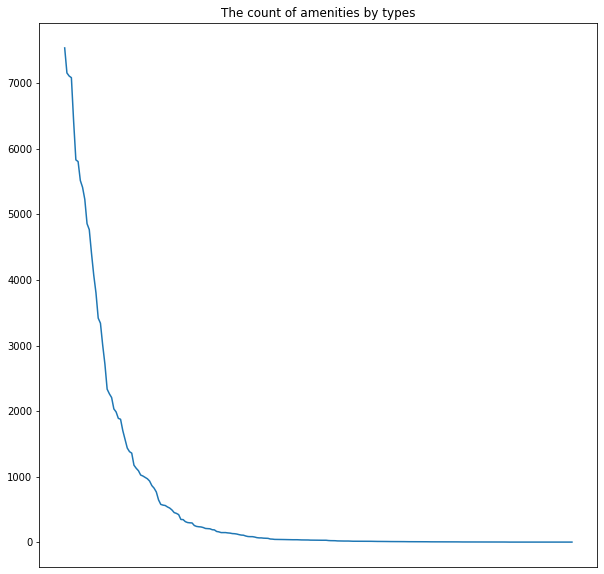

In [33]:
# Third step

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.plot(amenities_df.sum().sort_values(ascending=False))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title('The count of amenities by types')
plt.show()

Here, I see that at the value around 300, the count starts decreasing. I will leave only observations, where count value is greater than 300.

That lefts me with 63 dummy variables

In [34]:
# Third step: get rid of variables
amenities_df = amenities_df.loc[(amenities_df.sum(axis=1) >= 0),(amenities_df.sum(axis=0) >= 300)]

In [35]:
# Last step: merge with the original dataframe
data = data.drop(columns = ['amenities'], axis=1)
data = pd.concat([data, amenities_df], axis=1)
data.head()

,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,n_bathroom,bedrooms,beds,price,minimum_nights,maximum_nights,instant_bookable,f_bathroom,am_backyard,am_baking sheet,am_bathtub,am_bed linens,am_cable tv,am_carbon monoxide alarm,am_children\u2019s books and toys,am_cleaning products,am_clothing storage: wardrobe,am_coffee maker,am_cooking basics,am_crib,am_dedicated workspace,am_dining table,am_dishes and silverware,am_dishwasher,am_drying rack for clothing,am_elevator,am_essentials,am_ethernet connection,am_extra pillows and blankets,am_fire extinguisher,am_first aid kit,am_free parking on premises,am_free street parking,am_freezer,am_hangers,am_heating,am_high chair,am_host greets you,am_hot water,am_hot water kettle,am_iron,am_kitchen,am_lockbox,am_long term stays allowed,am_luggage dropoff allowed,am_microwave,am_nespresso machine,am_pack \u2019n play/travel crib,am_paid parking off premises,am_paid parking on premises,am_patio or balcony,am_portable fans,am_private entrance,am_room-darkening shades,am_security cameras on property,am_shower gel,am_single level home,am_smart lock,am_smoke alarm,am_toaster,am_washer,am_wine glasses,am__tv
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38768,True,True,Leopoldstadt,48.21924,16.37831,Apartment,5,1.0,1.0,3.0,$65.00,3,100,t,1,0,0,0,1,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
40625,True,True,Rudolfsheim-Fnfhaus,48.18434,16.32701,Apartment,6,1.0,2.0,4.0,$88.00,1,180,t,1,0,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0
51287,True,True,Leopoldstadt,48.21778,16.37847,Apartment,3,1.0,NaN,2.0,$60.00,3,100,t,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
75471,True,True,Ottakring,48.22207,16.31594,Apartment,4,1.0,2.0,2.0,$77.00,3,60,f,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,1,1,0,1,0,0,0,0,0,1,1,1,0,1,0,1,1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1
75500,True,True,Brigittenau,48.23500,16.36614,Apartment,4,1.0,2.0,2.0,$65.00,4,30,f,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1


#### Price

In [36]:
# Price 
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].str.replace('$', '')
calendar['price'] = calendar['price'].astype(float)

NameError: name 'calendar' is not defined

In [ ]:
data[data.property_type=="Entire rental unit"].describe()

In [ ]:
data["bathrooms_text"] = data["bathrooms_text"].astype(float)

In [ ]:
data.dtypes

In [ ]:
list(data.columns)

## Cleaning 